In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from string import punctuation
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing/Cleaning

In [2]:
df = pd.read_csv("Headlines.txt", engine="python", header=None, sep='\n')

In [3]:
df.head()

,0
0,Hydrogen has a major role to play in the clean...
1,"Students, doctors, children: Ukrainian airline..."
2,Poloz warns ‘froth’ could return to Canada’s h...
3,Canadian dollar seen losing upside momentum ov...
4,Sex worker Jamie Lee Hamilton sounded the alar...


In [4]:
print(len(df))

320


In [5]:
df.columns = ['Headline']
df.head()

,Headline
0,Hydrogen has a major role to play in the clean...
1,"Students, doctors, children: Ukrainian airline..."
2,Poloz warns ‘froth’ could return to Canada’s h...
3,Canadian dollar seen losing upside momentum ov...
4,Sex worker Jamie Lee Hamilton sounded the alar...


In [6]:
#Convert to lowercase, remove bad characters, and stopwords
def clean_text(text):
    text = text.lower()
    text = re.sub('/()\[\]{}@\$,;\'', '', text)
    text = re.sub('[^0-9a-z #+_]', '', text)
    text = ' '.join(word for word in text.split() if word not in english_stopwords)    
    
    return text

In [7]:
df['Headline'] = df['Headline'].apply(clean_text)

In [8]:
df.head()

,Headline
0,hydrogen major role play cleanenergy future pr...
1,students doctors children ukrainian airliner c...
2,poloz warns froth could return canadas housing...
3,canadian dollar seen losing upside momentum co...
4,sex worker jamie lee hamilton sounded alarm va...


In [9]:
def tokenize(text):
    stemmer = SnowballStemmer('english')    
    tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [10]:
def prepare_data(headlines):
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    X = vectorizer.fit_transform(headlines)
    words = vectorizer.get_feature_names()
    
    return X, words

In [11]:
X, words = prepare_data(df['Headline'].values)

# Clustering Model

C:\Users\rajpa\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (302). Possibly due to duplicate points in X.
  return_n_iter=True)


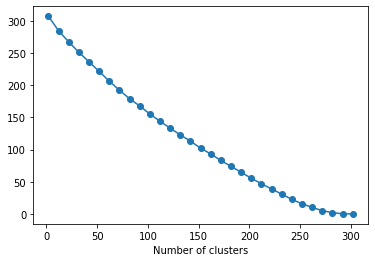

In [12]:
#Elbow method to determine optimal number of clusters
distortions =[] 
for i in range(2, 310, 10): 
    km = KMeans(n_clusters = i) 
    km.fit(X) 

    distortions.append(km.inertia_)
    
plt.plot(range(2, 310, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.show()

Using the elbow method, the optimal number of clusters is 295

C:\Users\rajpa\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (295) found smaller than n_clusters (302). Possibly due to duplicate points in X.
  return_n_iter=True)


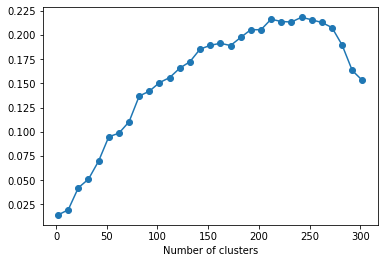

In [13]:
score =[] 
for i in range(2, 310, 10): 
    km = KMeans(n_clusters = i) 
    preds = km.fit_predict(X)
    
    score.append(silhouette_score(X, preds, metric='euclidean'))
    
plt.plot(range(2, 310, 10), score, marker='o')
plt.xlabel('Number of clusters')
plt.show()

Using the silhouette method, the optimal number of clusters is also 295

Using only 10 clusters because 295 is too much to analyze and will not help to understand the trending topics

In [17]:
kmeans = KMeans(n_clusters = 15).fit(X)

# Model Analysis

In [18]:
#Print the 10 most common words in each cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : canadian, vancouv, new, plan, assault, charg, trial, alberta, hostag, sexual
1 : shot, missil, jet, ukrainian, evid, say, trudeau, like, iran, offici
2 : ontario, strike, teacher, rotat, elementari, cost, farm, card, date, redandwhit
3 : canada, trudeau, flight, crash, iran, plane, investig, passeng, place, head
4 : quebec, tori, emerg, potenti, hope, leadership, poll, sure, hotspot, leader
5 : court, year, case, rule, canadian, regain, russian, bill, address, wetsuweten
6 : win, lotto, ticket, us, max, m, open, sold, first, canada
7 : say, trudeau, video, connect, pm, iran, crash, missil, canada, plane
8 : polic, bc, shoot, ottawa, rcmp, fatal, dead, indigen, one, say
9 : conserv, leadership, gladu, run, marilyn, mp, candid, parti, report, new
10 : trump, support, home, scene, anger, alon, canada, survey, cut, shame
11 : name, group, law, build, prevent, offend, saskatchewan, chang, sex, slaveri
12 : meghan, harri, holiday, thank, royal, move, princ, canada, christma, roamer
13 : 

Cluster 0: Assault related case in Vancouver <br>
Cluster 1: Ukraine plane strikes over Iran <br>
Cluster 2: Ontario schhol strike articles <br>
Cluster 3: More Ukraine plane articles <br>
Cluster 4: Quebec political articles <br>
Cluster 5: Judiciary articles <br>
Cluster 6: Lottery articles <br>
Cluster 7: Trudeau Iran articles <br>
Cluster 8: Police shooting articles  <br>
Cluster 9: Political articles <br>
Cluster 10: Trump budget cuts articles <br>
Cluster 11: ? <br>
Cluster 12: Royal family articles <br>
Cluster 13: Iraq war articles <br>
Cluster 14: Iranian plane articles <br>

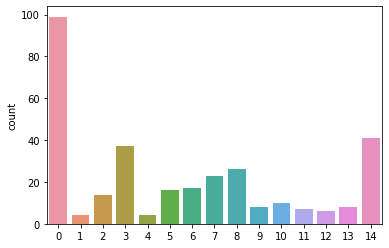

In [20]:
#Plot number of headlines in each cluster
sns.countplot(x=kmeans.labels_)
plt.show()